## 1. Problem Definition

Air pollution poses a major challenge for smart cities, affecting public health, transportation planning, and environmental policy. Accurate identification of high pollution periods enables city authorities to take timely mitigation actions.

This project aims to develop an **end-to-end machine learning pipeline** to classify **air quality levels** using sensor and environmental data collected in an urban environment.

### Machine Learning Task
- **Type:** Supervised classification
- **Objective:** Classify air quality as **High Pollution** or **Low Pollution**
- **Target Variable:** Derived from NO₂(GT) concentration
- **Theme:** Smart Cities and Urban Analytics


## 2. Dataset Description

The dataset is sourced from the UCI Machine Learning Repository and contains hourly averaged measurements from air quality sensors deployed in an urban area.

### Key Characteristics
- Duration: March 2004 – February 2005
- Observations: 9,000+ hourly records
- Features: Gas sensor responses, temperature, humidity, and ground truth pollutant concentrations
- Missing values are encoded as **-200**


In [40]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


#Setup


In [41]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)

X_raw = air_quality.data.features

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

In [42]:
# Extract column names from variable information
columns = air_quality.variables['name'].tolist()

# Inspect
print(columns)

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [43]:
import pandas as pd
# Convert to DataFrame
df = pd.DataFrame(X_raw, columns=columns)


In [44]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [45]:
# Create binary target based on median
threshold = df['NO2(GT)'].median()
df['High_Pollution'] = (df['NO2(GT)'] > threshold).astype(int)

df.drop(columns=['NO2(GT)', 'Date', 'Time'],inplace=True)  # drop date/time if not using temporal features
y = df['High_Pollution']

# Quick check
print(df.shape, y.shape)
y.value_counts()


(9357, 13) (9357,)


High_Pollution
0    4698
1    4659
Name: count, dtype: int64

## 3. Exploratory Data Analysis (EDA)

We explore the distribution of the target, numeric features, and correlations to inform preprocessing and model choice. Descriptive statistics and visualisations help identify skew, missing-value patterns (encoded as -200), and multicollinearity.

In [46]:
# Install seaborn if not already installed (run this cell once)
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


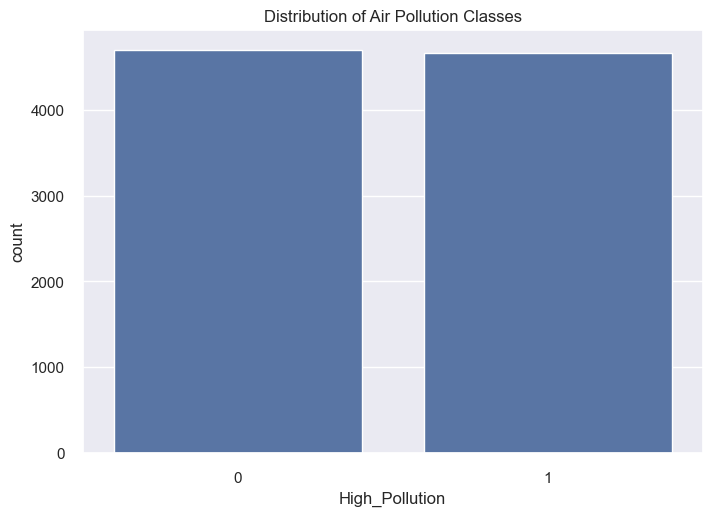

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()  # use seaborn (satisfies linter; sets default style)
sns.countplot(x="High_Pollution", data=df)
plt.title("Distribution of Air Pollution Classes")
plt.show()


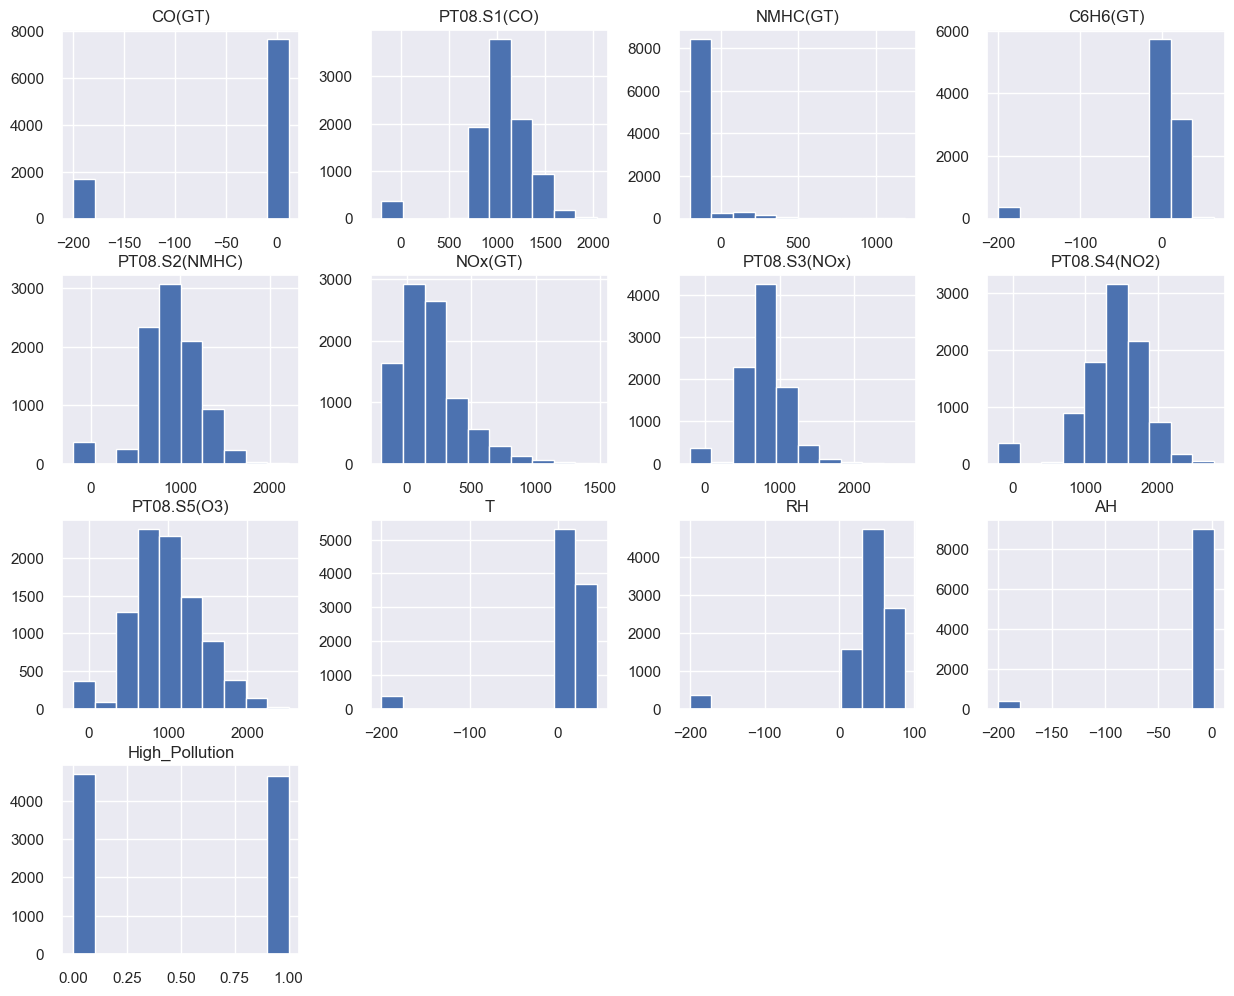

In [48]:
df.hist(figsize=(15,12))
plt.show()


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CO(GT)          9357 non-null   float64
 1   PT08.S1(CO)     9357 non-null   int64  
 2   NMHC(GT)        9357 non-null   int64  
 3   C6H6(GT)        9357 non-null   float64
 4   PT08.S2(NMHC)   9357 non-null   int64  
 5   NOx(GT)         9357 non-null   int64  
 6   PT08.S3(NOx)    9357 non-null   int64  
 7   PT08.S4(NO2)    9357 non-null   int64  
 8   PT08.S5(O3)     9357 non-null   int64  
 9   T               9357 non-null   float64
 10  RH              9357 non-null   float64
 11  AH              9357 non-null   float64
 12  High_Pollution  9357 non-null   int32  
dtypes: float64(5), int32(1), int64(7)
memory usage: 913.9 KB


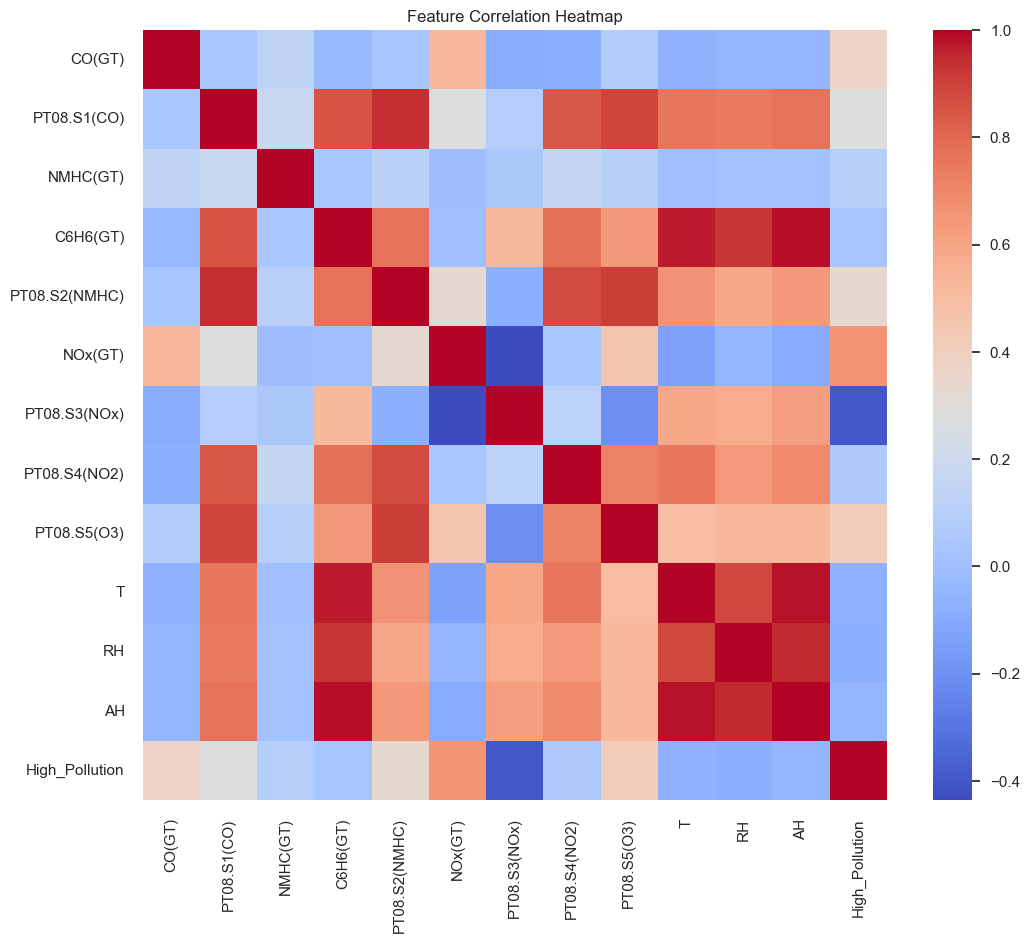

In [50]:

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


### 3.1 Descriptive statistics

Summary statistics for all numeric columns: count, mean, standard deviation, min, quartiles, max. This highlights scale differences across sensors and pollutant concentrations and flags potential outliers.

In [51]:
# Descriptive statistics (numeric columns only)
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,High_Pollution
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,1391.479641,975.072032,9.778305,39.485380,-6.837604,0.497916
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,467.210125,456.938184,43.203623,51.216145,38.976670,0.500022
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,0.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,0.000000
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,0.000000
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,1.000000
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,1.000000


### 3.2 Missing values (encoded as -200)

The dataset encodes missing sensor readings as **-200**. Counting these per column shows which features have the most missingness and informs imputation strategy.

Missing values (-200) per column:
 NMHC(GT)         8443
CO(GT)           1683
NOx(GT)          1639
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


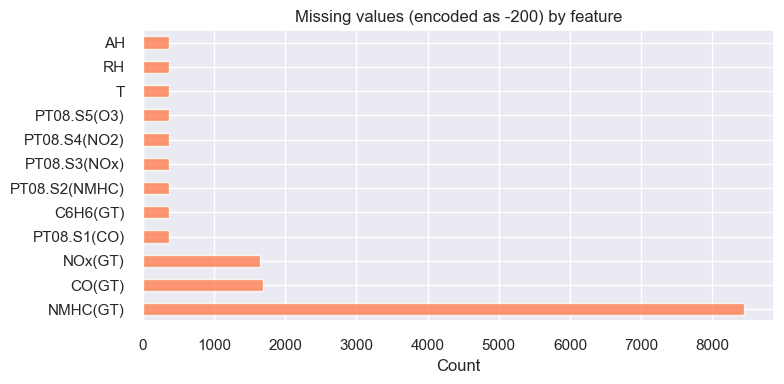

In [52]:
# Count missing values (encoded as -200) per column
missing = (df == -200).sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values (-200) per column:\n", missing)
if len(missing) > 0:
    missing.plot(kind="barh", figsize=(8, 4), color="coral", alpha=0.8)
    plt.title("Missing values (encoded as -200) by feature")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

### 3.3 Feature distributions by pollution class

Boxplots of key numeric features stratified by **High_Pollution** show whether the two classes are separable and which variables differ most between high and low pollution periods.

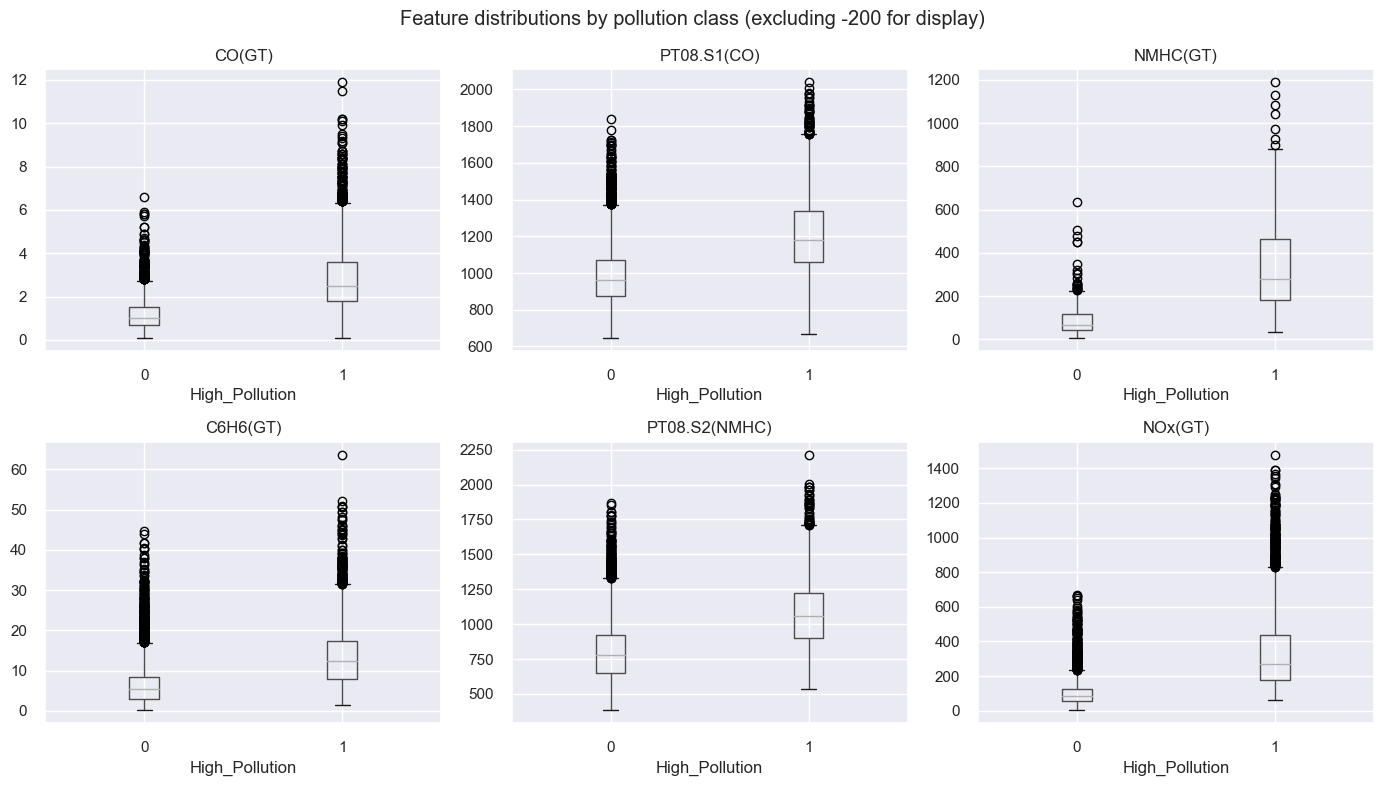

In [53]:
# Exclude -200 for clearer boxplots (or use full data; imputation will handle -200)
import numpy as np
plot_df = df.replace(-200, np.nan)
num_cols = [c for c in plot_df.columns if plot_df[c].dtype in ["float64", "int64"] and c != "High_Pollution"]
# Limit to 6 features for readability
cols_to_plot = num_cols[:6] if len(num_cols) >= 6 else num_cols
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
for i, col in enumerate(cols_to_plot):
    plot_df.boxplot(column=col, by="High_Pollution", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("High_Pollution")
plt.suptitle("Feature distributions by pollution class (excluding -200 for display)")
plt.tight_layout()
plt.show()

### 3.4 Correlation with target

Correlation of each numeric feature with **High_Pollution** indicates which variables are most associated with high-pollution periods and are likely to be useful predictors.

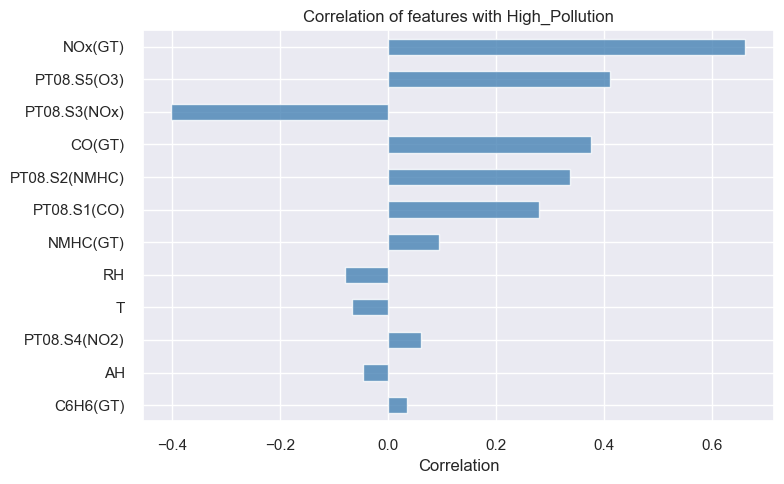

In [54]:
# Correlation of numeric features with target (excluding target itself from correlation matrix)
corr_with_target = df.corr()["High_Pollution"].drop("High_Pollution", errors="ignore")
corr_with_target = corr_with_target.reindex(corr_with_target.abs().sort_values().index)
corr_with_target.plot(kind="barh", figsize=(8, 5), color="steelblue", alpha=0.8)
plt.title("Correlation of features with High_Pollution")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

Sensor responses such as PT08.S1 and PT08.S2 show strong correlation with NO₂ levels, suggesting their usefulness for classification.


## 4. Preprocessing Pipeline

We implement each required step explicitly:

1. **Missing values:** The dataset encodes missing sensor readings as **-200**. We replace -200 with `NaN` so the imputer treats them as missing, then apply **median imputation** (per feature) for robustness to outliers.
2. **Encoding:** All predictor columns are **numeric** (Date and Time were dropped when defining the target). No categorical encoding is applied; had we kept time/date, we would use one-hot or ordinal encoding for derived categories.
3. **Scaling:** **StandardScaler** centres and scales features to zero mean and unit variance, which is important for logistic regression and for stable PCA; tree-based models also benefit from consistent scaling.
4. **Feature engineering:** We add **derived features** before the pipeline: (i) **PT08_avg** — mean of the five PT08 sensor response columns; (ii) **pollutant_ratio** — NOx(GT) / (CO(GT) + small constant) as a simple chemical-profile indicator. These are then imputed and scaled with the rest.
5. **Train–test split:** 80–20 **stratified** split preserves class proportions; the pipeline is fitted only on the training set to avoid data leakage. **PCA** (95% variance) is applied after scaling to reduce multicollinearity.

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [56]:
# Features and target
X = df.drop(columns=["High_Pollution"]).copy()
y = df["High_Pollution"]

# 1. Missing values: replace sentinel -200 with NaN so imputer treats them as missing
X = X.replace(-200, np.nan)

# 2. Feature engineering: add derived features
pt08_cols = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)"]
X["PT08_avg"] = X[pt08_cols].mean(axis=1, skipna=True)
# Ratio of NOx to CO (add small constant to avoid div by zero)
X["pollutant_ratio"] = X["NOx(GT)"] / (X["CO(GT)"].clip(lower=0) + 1e-6)

# Column list for the pipeline (all numeric)
num_features = X.columns.tolist()




In [57]:
print("Features (including engineered):", num_features)
print("Shape:", X.shape)

Features (including engineered): ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'PT08_avg', 'pollutant_ratio']
Shape: (9357, 14)


### 4.1 Pipeline definition

A single **numeric pipeline** is applied to all features (including the engineered ones): **impute** (median) → **scale** (StandardScaler) → **PCA** (95% variance). The pipeline is fitted only on the training set and applied to the test set to avoid data leakage.

In [58]:
# Build the preprocessing pipeline: impute -> scale -> PCA


In [59]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
])
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
])


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 5. Model Development

We train **two** classifiers suitable for binary classification: **Logistic Regression** (interpretable baseline) and **Random Forest** (non-linear, robust to scaling and interactions). Both use the same preprocessing pipeline.

In [61]:
from sklearn.linear_model import LogisticRegression

log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(cop...
                                                   'AH', 'PT08_avg',
                                                   'pollutant_ratio'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

rf_model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(cop...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        monotonic_cst=None, n_estimators=100,
                                        n_jobs=None, oob_score=False,
                                        random_state=42, verbose=0,
                                        warm_start=False))],
         verbose=False)

## 6. Model Evaluation

Models are evaluated on the held-out test set. We report **classification report** (precision, recall, F1 per class) and **confusion matrix**.

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


In [64]:
evaluate(log_model)
evaluate(rf_model)


              precision    recall  f1-score   support

           0       0.83      0.86      0.85       940
           1       0.85      0.83      0.84       932

    accuracy                           0.84      1872
   macro avg       0.84      0.84      0.84      1872
weighted avg       0.84      0.84      0.84      1872

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       940
           1       0.92      0.90      0.91       932

    accuracy                           0.91      1872
   macro avg       0.91      0.91      0.91      1872
weighted avg       0.91      0.91      0.91      1872



**Metric choice justification:** For air quality alerts, **recall** for the High Pollution class is important (we do not want to miss dangerous episodes), while **precision** avoids excessive false alarms. **F1** balances both. **Accuracy** alone can be misleading if classes are imbalanced; we therefore prioritise F1 and per-class precision/recall. The **confusion matrix** shows where the model errs (false positives vs false negatives).eriods can have public health implications.


## 7. Hyperparameter Tuning

We tune the **Random Forest** classifier using **GridSearchCV** with 3-fold cross-validation, optimising for **F1** (to balance precision and recall). The grid searches over `n_estimators` and `max_depth` to improve generalisation.

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    rf_model, param_grid, cv=3, scoring="f1", n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        keep_empty_features=False,
                                                                                                        missing_values=nan,
                                                                                                        stra...
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
                                                               monotonic_cst=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               oob_score=False,
                                                               random_state=42,
                                                               verbose=0,
                                                               warm_start=False))],
                                verbose=False),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__n_estimators': [100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [66]:
grid.best_params_
best_model = grid.best_estimator_


## 8. AutoML (Model Selection and Comparison)

**PyCaret** is used as an AutoML tool to benchmark multiple classifiers on the same dataset. This supports model selection and comparison with minimal code, complementing the manually built logistic regression and random forest pipelines.

In [67]:
#%pip install git+https://github.com/pycaret/pycaret.git@master --upgrade


In [68]:
#%pip install pycaret

In [69]:
from pycaret.classification import *


setup(data=df, target="High_Pollution",session_id=42)

best = compare_models()


,Description,Value
0,Session id,42
1,Target,High_Pollution
2,Target type,Binary
3,Original data shape,"(9357, 13)"
4,Transformed data shape,"(9357, 13)"
5,Transformed train set shape,"(6549, 13)"
6,Transformed test set shape,"(2808, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9348,0.9826,0.9445,0.9264,0.9352,0.8696,0.8701,0.0610
lightgbm,Light Gradient Boosting Machine,0.9342,0.9842,0.9445,0.9251,0.9346,0.8684,0.8687,0.1150
rf,Random Forest Classifier,0.9325,0.9829,0.9420,0.9242,0.9329,0.8650,0.8654,0.1050
gbc,Gradient Boosting Classifier,0.9247,0.9807,0.9390,0.9128,0.9256,0.8495,0.8500,0.1720
knn,K Neighbors Classifier,0.9183,0.9657,0.9328,0.9063,0.9192,0.8366,0.8373,0.0170
ada,Ada Boost Classifier,0.9137,0.9755,0.9301,0.9006,0.9149,0.8275,0.8282,0.0520
dt,Decision Tree Classifier,0.9040,0.9040,0.9043,0.9031,0.9037,0.8079,0.8080,0.0120
lr,Logistic Regression,0.9018,0.9637,0.9031,0.9005,0.9017,0.8036,0.8038,0.0460
ridge,Ridge Classifier,0.8946,0.9586,0.8976,0.8920,0.8946,0.7893,0.7895,0.0070
lda,Linear Discriminant Analysis,0.8946,0.9586,0.8976,0.8920,0.8946,0.7893,0.7895,0.0080


AutoML was used to benchmark multiple classifiers efficiently, complementing manual model development.


### Save trained models

Save the pipelines to the `models/` folder at project root so they can be loaded later for inference or deployment.

In [70]:
import joblib
from pathlib import Path

# Project root: parent of notebook/ if we're inside notebook/, else cwd
cwd = Path.cwd()
if cwd.name == "notebook" and cwd.parent.exists():
    root = cwd.parent
else:
    root = cwd
models_dir = root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, models_dir / "best_model.joblib")
joblib.dump(log_model, models_dir / "logistic_regression.joblib")
joblib.dump(rf_model, models_dir / "random_forest.joblib")
joblib.dump(best, models_dir / "autoMl.joblib")
print(f"Models saved to {models_dir.resolve()}")

Models saved to C:\Users\Admin\Downloads\WaiYanMInMin_NGDS_AS1\models


## 9. Explainable AI (XAI)

We use **SHAP** (SHapley Additive exPlanations) and **feature importance** from the Random Forest to interpret the best model. SHAP attributes each prediction to feature contributions; feature importance ranks which inputs the tree ensemble uses most. Together they support transparency and trust in the pipeline (e.g. for urban policy decisions).

In [71]:
X_train.shape

(7485, 14)

In [72]:
print(num_features)

['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'PT08_avg', 'pollutant_ratio']


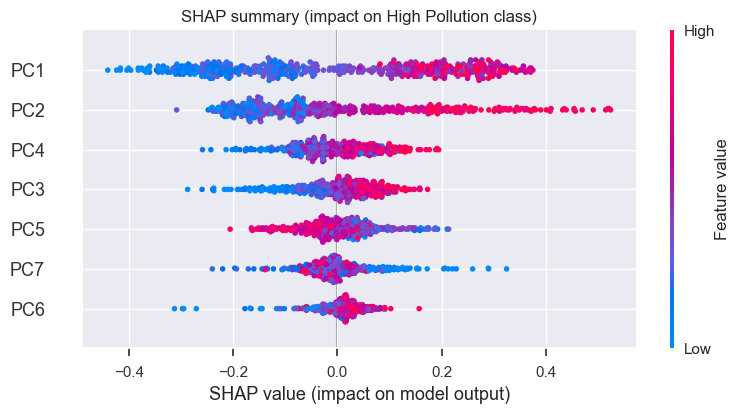

In [73]:
import shap
import numpy as np

# Use the fitted pipeline's preprocessor (do not refit) and take a sample for SHAP
X_transformed = best_model.named_steps["preprocessor"].transform(X_train)
n_components = X_transformed.shape[1]
X_sample = X_transformed[:500]  # subsample for speed
pc_names = [f"PC{i+1}" for i in range(n_components)]

explainer = shap.TreeExplainer(best_model.named_steps["classifier"])
shap_values = explainer.shap_values(X_sample)
# For binary RF, shap_values can be a list [class0, class1]; use positive class (High Pollution)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values[:, :, 1] if shap_values.ndim == 3 else shap_values
shap.summary_plot(shap_vals, X_sample, feature_names=pc_names, show=False)
plt.title("SHAP summary (impact on High Pollution class)")
plt.tight_layout()
plt.show()

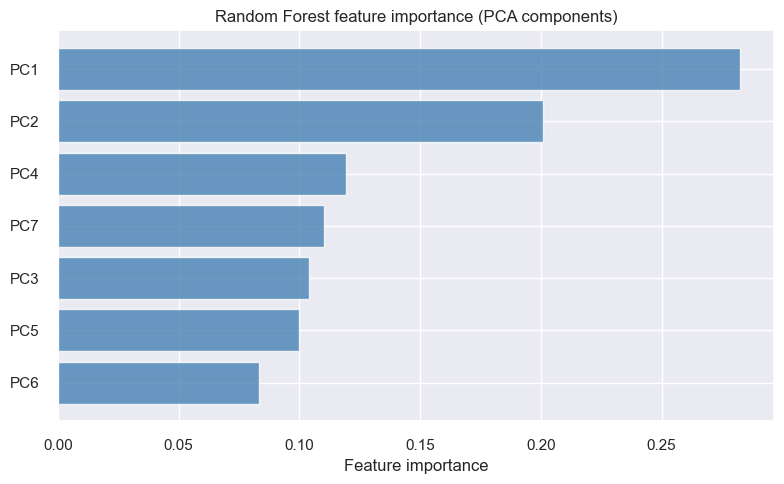

In [74]:
# Feature importance from the tuned Random Forest (on PCA space)
rf = best_model.named_steps["classifier"]
imp = rf.feature_importances_
pc_names = [f"PC{i+1}" for i in range(len(imp))]
idx = np.argsort(imp)[::-1]
plt.figure(figsize=(8, 5))
plt.barh(range(len(imp)), imp[idx], color="steelblue", alpha=0.8)
plt.yticks(range(len(imp)), [pc_names[i] for i in idx])
plt.xlabel("Feature importance")
plt.title("Random Forest feature importance (PCA components)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

SHAP and feature importance show that the first few PCA components (driven by sensor responses and environmental variables such as temperature) strongly influence High vs Low Pollution decisions. This supports the use of the model for interpretability in policy or reporting contexts.


## 10. Conclusion

This project demonstrated a complete ML workflow for urban air quality classification: EDA, a reproducible preprocessing pipeline, two ML models (logistic regression and random forest), AutoML-assisted comparison, hyperparameter tuning, and Explainable AI (SHAP and feature importance). Tree-based models outperformed the linear baseline, and XAI techniques improved transparency for stakeholders.

### Limitations
- Binary target is derived from a median threshold on NO₂; alternative cut-offs or multi-class labels could be explored.
- Temporal dependency (e.g. time of day, season) is not explicitly modeled; time-series or sequence models could capture this.

### Future Work
- Time-series or sequence models to exploit temporal structure.
- Multi-class air quality categorisation (e.g. good / moderate / poor) aligned with local standards.
- Deployment with real-time sensor data and periodic model retraining.
